In [1]:
pip install pandas matplotlib

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le dataset
df = pd.read_csv("power.csv")

In [3]:
# Chercher les valeurs NaN
nan_values = df.isna().sum()

# Afficher les valeurs NaN
print("Valeurs NaN dans chaque colonne :")
print(nan_values)


Valeurs NaN dans chaque colonne :
dt                          0
Global_active_power      4070
Global_reactive_power    4070
dtype: int64


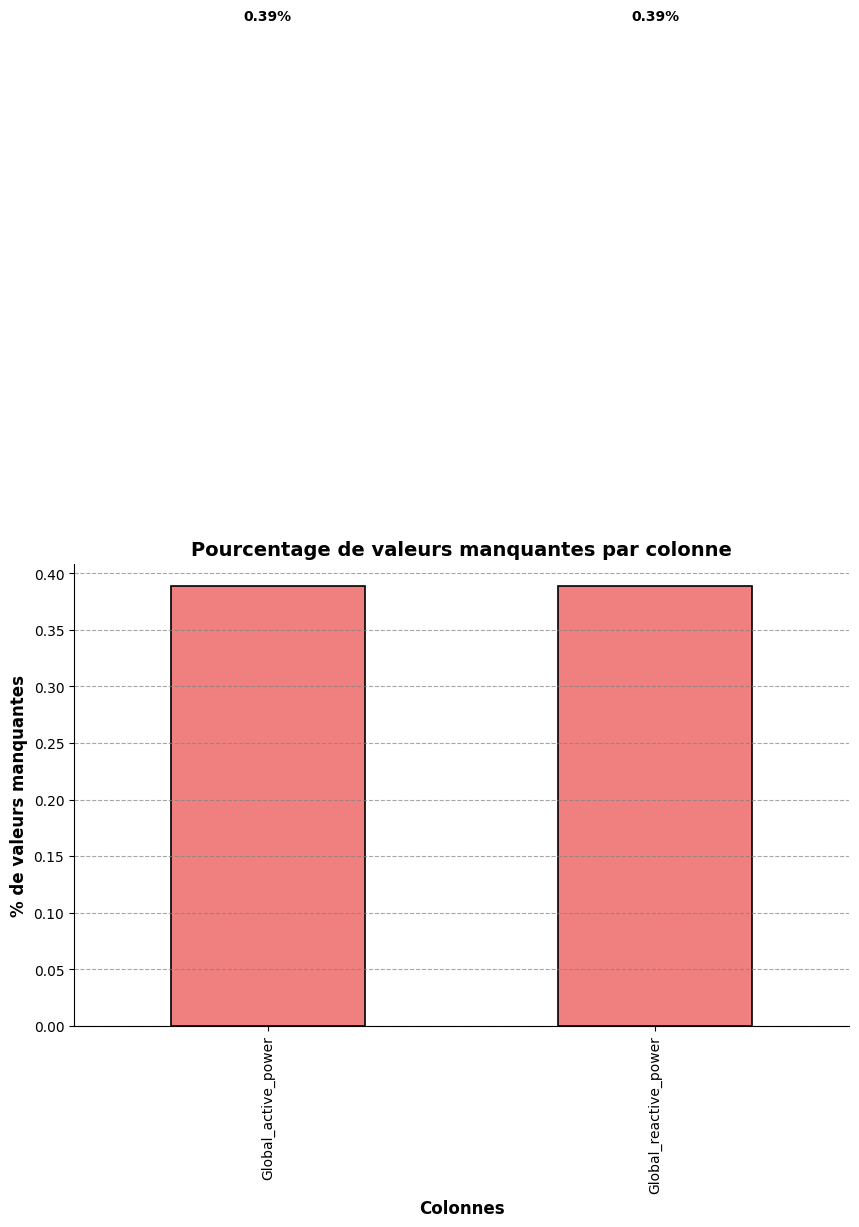

In [18]:
import matplotlib.pyplot as plt

# Créer une figure avec un axe
fig, ax = plt.subplots(figsize=(10, 6))

# Calculer le pourcentage de valeurs manquantes par colonne
pourcentage_nan = (df.isnull().sum() / len(df)) * 100

bar_colors = ['skyblue' if value == 0 else 'lightcoral' for value in pourcentage_nan]

# Créer un diagramme en barres
pourcentage_nan.plot(kind='bar', color=bar_colors, edgecolor='black', linewidth=1.2)

# Ajouter des étiquettes et un titre
plt.xlabel('Colonnes', fontweight='bold', fontsize=12)
plt.ylabel('% de valeurs manquantes', fontweight='bold', fontsize=12)
plt.title('Pourcentage de valeurs manquantes par colonne', fontweight='bold', fontsize=14)

# Afficher le pourcentage au-dessus de chaque barre
for index, value in enumerate(pourcentage_nan):
    plt.text(index, value + 0.5, f'{value:.2f}%', ha='center', fontweight='bold', fontsize=10, color='black')

# Personnaliser l'apparence de l'axe
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)

# Afficher le diagramme en barres
plt.show()


In [5]:
# Supprimer les colonnes inutiles
df = df.drop('dt', axis=1)

In [6]:
#sauvegader le nouveau dataset
df.to_csv("nv_power.csv", index=False)

In [7]:
# Afficher le nombre de classes (uniques) dans une colonne
nombre_classe_active = df['Global_active_power'].nunique()
nombre_classe_reactive = df['Global_reactive_power'].nunique()
print(f"Le nombre de classes uniques dans la colonne Global active power est : {nombre_classe_active}")
print(f"Le nombre de classes uniques dans la colone Global reactive power est : {nombre_classe_reactive}")

Le nombre de classes uniques dans la colonne Global active power est : 4075
Le nombre de classes uniques dans la colone Global reactive power est : 491


In [8]:
pip install tensorflow scikit-learn

In [9]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [10]:
# Charger le nouveau dataset
df = pd.read_csv("nv_power.csv")

In [11]:
# Sélectionner la colonne cible et les caractéristiques
target_column = 'Global_active_power'
features = df.drop(target_column, axis=1)

In [12]:
# Normaliser les données
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)


In [13]:
# Créer des séquences temporelles
sequence_length = 10  # ajustez la séquence selon vos besoins
X, y = [], []
for i in range(len(df_scaled) - sequence_length):
    X.append(df_scaled[i:i+sequence_length])
    y.append(df_scaled[i+sequence_length, df.columns.get_loc(target_column)])

X, y = np.array(X), np.array(y)

In [14]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Créer le modèle LSTM
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [16]:
!nvidia-smi



Fri Dec 29 08:24:16 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0              28W /  70W |    107MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [19]:
# Entraîner le modèle
model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test))

from tensorflow.keras.callbacks import ModelCheckpoint

# Définir le chemin où sauvegarder les modèles sur Google Drive (adaptez le chemin selon votre besoin)
checkpoint_path = "modele/model_{epoch:02d}.h5"

# Créer le callback ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=False,  # Sauvegarder tout le modèle, pas seulement les poids
    save_best_only=False,     # Sauvegarder tous les modèles, pas seulement le meilleur
    monitor='val_loss',       # Surveiller la perte sur l'ensemble de validation
    mode='min',               # Mode 'min' signifie que le modèle sera sauvegardé lorsque la métrique est minimisée
    verbose=1                  # Afficher des messages pendant l'entraînement
)

# Utiliser le callback lors de l'entraînement du modèle
model.fit(
    X_train, y_train,
    epochs=2,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_callback]
)


Epoch 1/2
26162/26162 [==============================] - 364s 14ms/step - loss: nan - val_loss: nan
Epoch 2/2
26162/26162 [==============================] - 352s 13ms/step - loss: nan - val_loss: nan


NameError: ignored

In [ ]:
# Évaluer le modèle
loss = model.evaluate(X_test, y_test)
print(f'Loss (Mean Squared Error) : {loss}')

# Faire des prédictions sur les données de test
predictions = model.predict(X_test)



In [ ]:
predictions = predictions.reshape(-1, 2)

predictions = scaler.inverse_transform(predictions)

In [ ]:
# Comparer les prédictions avec les valeurs réelles
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valeurs Réelles')
plt.plot(predictions, label='Prédictions')
plt.title('Prédictions de Global_active_power avec un modèle LSTM')
plt.xlabel('Indice de l\'échantillon')
plt.ylabel('Global_active_power')
plt.legend()
plt.show()